# Método de Tarner

In [4]:
%matplotlib inline

import pandas
import numpy
import matplotlib.pyplot as plt

## Definição das entradas

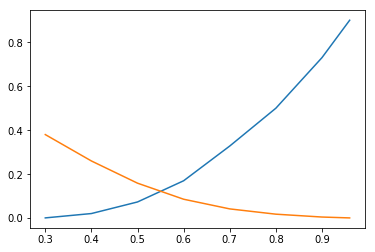

In [5]:
Sw_i = 0.2

pvt = pandas.DataFrame({
    'P' : [260., 220., 180., 140., 100., 80., 60., 40.],
    'Rs' : [100., 100., 100., 83., 66., 57., 49., 40.],
    'Bo' : [1.310, 1.322, 1.333, 1.276, 1.221, 1.193, 1.162, 1.137],
    'Bg' : [0.003846, 0.004545, 0.005556, 0.007143, 0.010000, 0.012500, 0.016667, 0.025000],
    'uo' : [1.60, 1.55, 1.50, 1.61, 1.81, 2.01, 2.24, 2.68],
    'ug' : [0.028, 0.026, 0.023, 0.020, 0.016, 0.014, 0.012, 0.010] })
pvt.set_index('P', inplace=True)

kro = pandas.Series([0.9000, 0.7300, 0.5000, 0.3280, 0.1700, 0.0736, 0.0209, 0.0011])
krg = pandas.Series([0.0010, 0.0050, 0.0180, 0.0420, 0.0860, 0.1590, 0.2600, 0.3800])
sliq = pandas.Series([0.96, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30])

kr = pandas.DataFrame({
    'Sliquido' : sliq,
    'Kro' : kro,
    'Krg' : krg,
    'Kg/Ko' : [kg/ko for ko, kg in zip(kro, krg)] })
kr.set_index('Sliquido', inplace=True)

plt.plot(sliq, kr['Kro'])
plt.plot(sliq, kr['Krg'])

plt.show()

## Identificar pressão de bolha e erro tolerável

In [6]:
pbubble = 180.0
tolerance = 0.0001

## Métodos para calcular DeltaGp/N por balanço de massa

In [7]:
def calc_Rp(Bo, Bo_i, Bg, Rs, Rs_i, Np_N_ratio):
    first_term = Bo - Bo_i + Bg*(Rs_i - Rs)
    second_term = (Bo - Rs*Bg)*Np_N_ratio
    quocient = Bg*Np_N_ratio
    return (first_term - second_term)/quocient

def calc_Gp_N_ratio(Np_N_ratio, Rp):
    return Np_N_ratio*Rp

## Métodos para calcular DeltaGp/N pela RGO

In [8]:
def calc_So(Np_N_ratio, Bo, Bo_i, Sw_i):
    return (1-Np_N_ratio)*Bo*(1-Sw_i)/Bo_i

def calc_Sliq(So, Sw_i):
    return So + Sw_i

def calc_Krg_Kro_ratio(kr_dataframe, Sliq):
    kr_tmp = kr_dataframe.copy()
    kr_tmp.loc[Sliq] = {
        'Kro' : numpy.nan,
        'Krg' : numpy.nan,
        'Kg/Ko' : numpy.nan}

    kr_tmp.sort_index(inplace=True)
    kr_tmp.interpolate(method='values', inplace=True)
    kr_tmp['Kg/Ko'][Sliq] = kr_tmp['Krg'][Sliq]/kr_tmp['Kro'][Sliq]
    return kr_tmp['Kg/Ko'][Sliq]

def calc_rgo(krg_kro_ratio, Rs, uo, ug, Bo, Bg):
    return Rs + krg_kro_ratio*(uo/ug)*(Bo/Bg)

## Estratégia para estimar Np/N

![title](assets/DeltaGP_EBM_RGO.png)

In [9]:
class NpRatioEstimator(object):
    def __init__(self, isCumulative=False):
        super(NpRatioEstimator, self).__init__()
        self.isCumulative = isCumulative
        self.step = 0.0001
        self.reset()
    
    def reset(self):
        self.min_ratio = 0
        self.max_ratio = 1
        self.current_ratio = 0.000001
        
    def next(self, delta_Gp_EBM, delta_Gp_RGO):
        if self.isCumulative:
            self.current_ratio += self.step
        else:
            if delta_Gp_EBM > delta_Gp_RGO:
                if self.current_ratio > self.min_ratio:
                    self.min_ratio = self.current_ratio
            elif delta_Gp_EBM < delta_Gp_RGO:
                if self.current_ratio < self.max_ratio:
                    self.max_ratio = self.current_ratio
        
            self.current_ratio = (self.max_ratio + self.min_ratio)/2
        return self.current_ratio

## Método de Tarner

In [10]:
# Ordenar tabela PVT em ordem decrescente de pressão
ordered_pvt = pvt.sort_index(ascending=False)
pressures_desc_order = ordered_pvt.index

# Obtém índice da pressão de bolha escolhida
p_index = pressures_desc_order.get_loc(pbubble)

# Obtém valores de Rs e Bo na pressão de bolha
Rs_i = pvt['Rs'][pbubble]
Bo_i = pvt['Bo'][pbubble]

#Variáveis da iteração anterior
prev_Gp_N_ratio_EBM = 0
prev_Np_N_ratio = 0
prev_rgo = Rs_i

#Variáveis da iteração atual
Gp_N_ratio_EBM = 0
Np_N_ratio = 0
rgo = Rs_i

# Dataframe contendo a resposta
answer = pandas.DataFrame({
    'P': [],
    'Np/N': [],
    'RGO': []
})
answer.set_index('P', inplace=True)

# Inicializando estimador de Np/N
estimator = NpRatioEstimator(False)

for i in range(p_index + 1, pressures_desc_order.size):
    # "1) Faça n=n+1 e escolha uma pressão menor do que a anterior (Pn+1 < Pn)"
    pressure = pressures_desc_order[i]

    # "2) Com Pn+1 e a análise PVT obtemos Bo, Rs, Bg, μο e μg"
    pvt_data = ordered_pvt.iloc[i]

    # Reseta as variáveis para a próxima iteração
    delta_Gp_N_ratio_EBM = 0
    delta_Gp_N_ratio_RGO = 0

    prev_rgo = rgo
    prev_Np_N_ratio = Np_N_ratio
    prev_Gp_N_ratio_EBM = Gp_N_ratio_EBM

    error = 1
    estimator.reset()
    
    while error >= tolerance:
        # "3) Estimar Npn+1 > Npn"
        Np_N_ratio = estimator.next(delta_Gp_N_ratio_EBM, delta_Gp_N_ratio_RGO)

        # "4) Calcular a Rpn+1 usando Npn+1 e os dados PVT (Eq. 2.1)"
        Rp = calc_Rp(
            pvt_data['Bo'],
            Bo_i,
            pvt_data['Bg'],
            pvt_data['Rs'],
            Rs_i,
            Np_N_ratio
        )

        # "5) Calcular Gpn+1 = Npn+1.Rpn+1"
        Gp_N_ratio_EBM = calc_Gp_N_ratio(Np_N_ratio, Rp)
        
        # "6) Calcular ΔGp1 = Gpn+1 - Gpn"
        delta_Gp_N_ratio_EBM = Gp_N_ratio_EBM - prev_Gp_N_ratio_EBM

        # "7) Calcular a saturação de óleo (Eq. 3.4) e a de líquido (Sliq = So + Swi)"
        new_So = calc_So(
            Np_N_ratio,
            pvt_data['Bo'],
            Bo_i,
            Sw_i
        )
        new_Sliq = calc_Sliq(new_So, Sw_i)

        # "8) Com a Sliq obter (Krg/Kro) das curvas de permeabilidade relativa"
        new_Krg_Kro_ratio = calc_Krg_Kro_ratio(kr, new_Sliq)
        
        # "9) Calcular a RGOn+1 usando (Krg/Kro) e os dados PVT (Eq. 5.4)"
        rgo = calc_rgo(
            new_Krg_Kro_ratio, 
            pvt_data['Rs'],
            pvt_data['uo'],
            pvt_data['ug'],
            pvt_data['Bo'],
            pvt_data['Bg']
        )

        # "10) Calcular a RGO média entre os tempos n e n+1: Rm = (RGOn+1+RGOn)/2"
        mean_rgo = (rgo + prev_rgo)/2
        
        # "11) Calcular ΔGp2 = ΔNpn+1. Rm"
        delta_Gp_N_ratio_RGO = mean_rgo * (Np_N_ratio - prev_Np_N_ratio)

        error = abs((delta_Gp_N_ratio_RGO - delta_Gp_N_ratio_EBM)/delta_Gp_N_ratio_EBM)

    answer.loc[pressure] = {
        'Np/N': Np_N_ratio,
        'RGO': rgo
    }            

answer

,Np/N,RGO
P,,
140.0,0.042648,131.719098
100.0,0.100571,290.136246
80.0,0.127876,422.247922
60.0,0.149498,572.899984
40.0,0.169910,758.135495
